<h1>Mlp</h1>
A continuation of the andrej karpathy series where we develop on the makemore model to a mlp for character level prediction. It is based on the following paper <a href="https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf"> link </a>

In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 

In [2]:
words = open("names.txt").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [3]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

We can implement embeddings or the look up table converting an integer to an embedding. it will take in the 27 characters as inputs and return a 2 dimensional embedding as a result 

In [4]:
X.shape

torch.Size([228146, 3])

In [5]:
C = torch.randn(27,2)
C.shape

torch.Size([27, 2])

In [6]:
one_hot = F.one_hot(torch.tensor(4), 27).float()
one_hot.shape

torch.Size([27])

In [7]:
one_hot @ C

tensor([0.0123, 0.6566])

In [8]:
X.shape

torch.Size([228146, 3])

We can then pass these embeddings into a linear layer by concatenating all 3 embeddings before passing them into a layer with an activation function of tanh

In [9]:
emb = C[X]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [10]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2

In [11]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)

In [12]:
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(17.2646)

We can clean up the code to make it well more respectable and readable. Note the use of F.cross entropy is recommended as it is optimised to make forward pass faster. It is also more efficient in the backward pass as the backward() method is derived in one step

In [13]:
g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [c, W1, b1, W2, b2]

In [14]:
sum (p.nelement() for p in parameters)

3481

In [135]:
emb = c[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2
F.cross_entropy(logits, Y)


tensor(19.1425)

We can then train the neural network to overfit on the dataset

In [136]:
for p in parameters:
    p.requires_grad = True

In [140]:
for _ in range(10000):
    minibatch = torch.randint(0, X.shape[0], (128,))
    emb = c[X[minibatch]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])
    for p in parameters:
        p.grad = None

    loss.backward()
    for p in parameters:
        p.data += -p.grad * 0.01

    print(loss)

tensor(2.4845, grad_fn=<NllLossBackward0>)
tensor(2.5772, grad_fn=<NllLossBackward0>)
tensor(2.5639, grad_fn=<NllLossBackward0>)
tensor(2.7138, grad_fn=<NllLossBackward0>)
tensor(2.4961, grad_fn=<NllLossBackward0>)
tensor(2.4356, grad_fn=<NllLossBackward0>)
tensor(2.6345, grad_fn=<NllLossBackward0>)
tensor(2.6298, grad_fn=<NllLossBackward0>)
tensor(2.6882, grad_fn=<NllLossBackward0>)
tensor(2.5656, grad_fn=<NllLossBackward0>)
tensor(2.6065, grad_fn=<NllLossBackward0>)
tensor(2.6679, grad_fn=<NllLossBackward0>)
tensor(2.4911, grad_fn=<NllLossBackward0>)
tensor(2.5572, grad_fn=<NllLossBackward0>)
tensor(2.5293, grad_fn=<NllLossBackward0>)
tensor(2.6011, grad_fn=<NllLossBackward0>)
tensor(2.7472, grad_fn=<NllLossBackward0>)
tensor(2.5703, grad_fn=<NllLossBackward0>)
tensor(2.5463, grad_fn=<NllLossBackward0>)
tensor(2.6371, grad_fn=<NllLossBackward0>)
tensor(2.4613, grad_fn=<NllLossBackward0>)
tensor(2.6097, grad_fn=<NllLossBackward0>)
tensor(2.5502, grad_fn=<NllLossBackward0>)
tensor(2.50

We can also sample the data in minibatches in order to train on our whole dataset in a reasonable amout of time

In [79]:
lre = torch.linspace(-0.001, -1, 1000)
steplist = []
losslist = []

for i in range(1000):
    minibatch = torch.randint(0, X.shape[0], (128,))
    emb = c[X[minibatch]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])
    for p in parameters:
        p.grad = None


    loss.backward()
    for p in parameters:
        p.data += p.grad * lre[i]

    print(loss)
    steplist.append(i)
    losslist.append(loss.item())
    

tensor(3.2828, grad_fn=<NllLossBackward0>)
tensor(2.9272, grad_fn=<NllLossBackward0>)
tensor(2.9834, grad_fn=<NllLossBackward0>)
tensor(2.7617, grad_fn=<NllLossBackward0>)
tensor(3.0411, grad_fn=<NllLossBackward0>)
tensor(2.8250, grad_fn=<NllLossBackward0>)
tensor(2.9159, grad_fn=<NllLossBackward0>)
tensor(2.8695, grad_fn=<NllLossBackward0>)
tensor(2.7703, grad_fn=<NllLossBackward0>)
tensor(2.8313, grad_fn=<NllLossBackward0>)
tensor(2.8424, grad_fn=<NllLossBackward0>)
tensor(2.9987, grad_fn=<NllLossBackward0>)
tensor(2.5474, grad_fn=<NllLossBackward0>)
tensor(2.9580, grad_fn=<NllLossBackward0>)
tensor(2.8785, grad_fn=<NllLossBackward0>)
tensor(2.8713, grad_fn=<NllLossBackward0>)
tensor(2.5895, grad_fn=<NllLossBackward0>)
tensor(2.6848, grad_fn=<NllLossBackward0>)
tensor(2.6626, grad_fn=<NllLossBackward0>)
tensor(2.8917, grad_fn=<NllLossBackward0>)
tensor(2.5521, grad_fn=<NllLossBackward0>)
tensor(2.6444, grad_fn=<NllLossBackward0>)
tensor(2.5874, grad_fn=<NllLossBackward0>)
tensor(2.75

You can find the optimum learning rate by plotting how the model reacts to different loss functions and based on the graph choose the adequate learning rate 

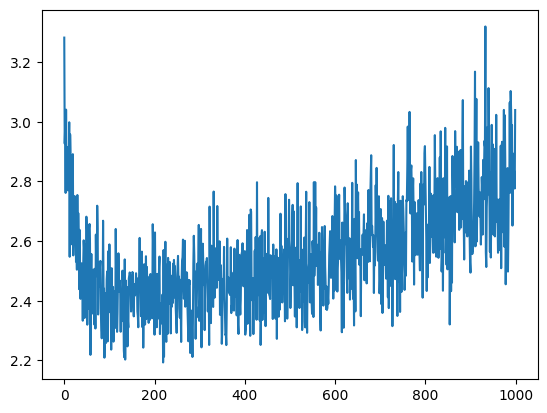

In [80]:
plt.plot(steplist, losslist)

In order to avoid overfitting the data is partitioned into 3 splits 
- Train = for the actual training of the model 
- Val/Dev = for training the hyper parameters
- Test = for evaluating the models performance 

In [57]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

In [58]:
import random 
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

We can finally sample from the model using the following code 

In [180]:
for _ in range(10000):
    minibatch = torch.randint(0, X.shape[0], (128,))
    emb = c[X[minibatch]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])
    for p in parameters:
        p.grad = None

    loss.backward()
    for p in parameters:
        p.data += -p.grad * 0.01

    print(loss)

tensor(2.3246, grad_fn=<NllLossBackward0>)
tensor(2.4599, grad_fn=<NllLossBackward0>)
tensor(2.5132, grad_fn=<NllLossBackward0>)
tensor(2.5033, grad_fn=<NllLossBackward0>)
tensor(2.3668, grad_fn=<NllLossBackward0>)
tensor(2.6036, grad_fn=<NllLossBackward0>)
tensor(2.4629, grad_fn=<NllLossBackward0>)
tensor(2.3154, grad_fn=<NllLossBackward0>)
tensor(2.4030, grad_fn=<NllLossBackward0>)
tensor(2.5136, grad_fn=<NllLossBackward0>)
tensor(2.5501, grad_fn=<NllLossBackward0>)
tensor(2.4406, grad_fn=<NllLossBackward0>)
tensor(2.5151, grad_fn=<NllLossBackward0>)
tensor(2.2692, grad_fn=<NllLossBackward0>)
tensor(2.4457, grad_fn=<NllLossBackward0>)
tensor(2.4391, grad_fn=<NllLossBackward0>)
tensor(2.5025, grad_fn=<NllLossBackward0>)
tensor(2.5600, grad_fn=<NllLossBackward0>)
tensor(2.4405, grad_fn=<NllLossBackward0>)
tensor(2.5236, grad_fn=<NllLossBackward0>)
tensor(2.6672, grad_fn=<NllLossBackward0>)
tensor(2.3857, grad_fn=<NllLossBackward0>)
tensor(2.6105, grad_fn=<NllLossBackward0>)
tensor(2.29

In [148]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if (ix == 0):
            break

    print("".join(out))

bjeliao.
jji.
jjuhgyvuubjeai.
jjpai.
jjj.
jje.
jjuhgoebbaelo.
jjeh.
jjuhai.
jjeriaoeji.
